In [1]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

# The training data path should be updated to your actual training file.
TRAIN_DATA_PATH = "./kaggle/train.csv"
SPY_DATA_PATH = "./kaggle/spy-historical.csv"

def generate_features_7 (df: pl.DataFrame) -> pl.DataFrame:
  """Generates new features from the base data.
    This function is the target of the evolutionary algorithm.
  
    Available Feature Categories:
    - D* (Dummy/Binary features): 9 columns (D1-D9)
    - E* (Macro Economic features): 20 columns (E1-E20)
    - I* (Interest Rate features): 9 columns (I1-I9)
    - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
    - P* (Price/Valuation features): 13 columns (P1-P13)
    - S* (Sentiment features): 12 columns (S1-S12)
    - V* (Volatility features): 13 columns (V1-V13)
  """
  new_features = pl.DataFrame({
      # --- 20 Pairwise Interactions ---
      'feat_M1_x_V1': df['M1'] * df['V1'],
      'feat_P1_add_E1': df['P1'] + df['E1'],
      'feat_S1_sub_I1': df['S1'] - df['I1'],
      'feat_M10_div_V10': df['M10'] / (df['V10'] + 1e-6),
      'feat_P10_x_E10': df['P10'] * df['E10'],
      'feat_M2_x_S3': df['M2'] * df['S3'],
      'feat_V2_div_P2': df['V2'] / (df['P2'] + 1e-6),
      'feat_E4_sub_I3': df['E4'] - df['I3'],
      'feat_S7_add_M12': df['S7'] + df['M12'],
      'feat_I5_x_V11': df['I5'] * df['V11'],
      'feat_P5_div_S8': df['P5'] / (df['S8'] + 1e-6),
      'feat_E12_x_I9': df['E12'] * df['I9'],
      'feat_M1_div_S1': df['M1'] / (df['S1'] + 1e-6),
      'feat_V1_add_P1': df['V1'] + df['P1'],
      'feat_E1_sub_I1': df['E1'] - df['I1'],
      'feat_M2_div_V2': df['M2'] / (df['V2'] + 1e-6),
      'feat_P2_x_S3': df['P2'] * df['S3'],
      'feat_E4_add_M10': df['E4'] + df['M10'],
      'feat_I3_sub_V10': df['I3'] - df['V10'],
      'feat_S7_x_P10': df['S7'] * df['P10'],
      # --- 10 Rolling Window Features ---
      'feat_V2_roll_mean_5': df['V2'].rolling_mean(window_size=5),
      'feat_V1_roll_std_5': df['V1'].rolling_std(window_size=5),
      'feat_M1_roll_mean_20': df['M1'].rolling_mean(window_size=20),
      'feat_M3_roll_std_20': df['M3'].rolling_std(window_size=20),
      'feat_P1_roll_max_10': df['P1'].rolling_max(window_size=10),
      'feat_P1_roll_min_10': df['P1'].rolling_min(window_size=10),
      'feat_E5_roll_mean_50': df['E5'].rolling_mean(window_size=50),
      'feat_S1_roll_std_50': df['S1'].rolling_std(window_size=50),
      'feat_I1_roll_mean_10': df['I1'].rolling_mean(window_size=10),
      'feat_V10_roll_std_10': df['V10'].rolling_std(window_size=10),
      # --- 10 Complex Interactions (3+ elements) ---
      'feat_M1_V1_div_P1': (df['M1'] * df['V1']) / (df['P1'] + 1e-6),
      'feat_E1_S1_add_I1': df['E1'] + df['S1'] - df['I1'],
      'feat_M2_P2_sub_V2': df['M2'] + df['P2'] - df['V2'],
      'feat_S7_div_E4_I3': df['S7'] / (df['E4'] + df['I3'] + 1e-6),
      'feat_P5_x_M10_x_V10': df['P5'] * df['M10'] * df['V10'],
      'feat_roll_diff_M1_5_20': df['M1'].rolling_mean(window_size=5) - df['M1'].rolling_mean(window_size=20),
      'feat_roll_diff_V1_5_20': df['V1'].rolling_mean(window_size=5) - df['V1'].rolling_mean(window_size=20),
      'feat_M_S_P_combo': (df['M12'] - df['M1']) / (df['S1'] + df['P1'] + 1e-6),
      'feat_V_E_I_combo': (df['V11'] + df['V2']) * (df['E1'] - df['I1']),
      'feat_ratio_of_ratios': (df['M1']/(df['V1']+1e-6)) / (df['P1']/(df['S1']+1e-6)),
      # --- 10 New Features ---
      'feat_M1_x_V1_x_P1': df['M1'] * df['V1'] * df['P1'],
      'feat_E1_div_S1': df['E1'] / (df['S1'] + 1e-6),
      'feat_I1_sub_V1': df['I1'] - df['V1'],
      'feat_M10_add_V10': df['M10'] + df['V10'],
      'feat_P10_div_E10': df['P10'] / (df['E10'] + 1e-6),
      'feat_M2_add_S3': df['M2'] + df['S3'],
      'feat_V2_x_P2': df['V2'] * df['P2'],
      'feat_E4_add_I3': df['E4'] + df['I3'],
      'feat_S7_div_M12': df['S7'] / (df['M12'] + 1e-6),
      'feat_I5_div_V11': df['I5'] / (df['V11'] + 1e-6),
      #'feat_M1_log_P1': np.log(df['M1'] + 1e-6) / np.log(df['P1'] + 1e-6),
      # --- SAFER LOGIC HERE ---
      #'feat_M1_log_P1': pl.when( (df['M1'] > 0) & (df['P1'] > 0) & (df['P1'] != 1) ).then( df['M1'].log() / df['P1'].log() ).otherwise(0),
      # --- END SAFER LOGIC ---
  })
  # Fill any nulls created by rolling windows
  return new_features.with_columns(pl.all().forward_fill())



In [ ]:
#solve: daily reranking, no pruning

def solve(df: pl.DataFrame) -> float:
    """
    Runs a time-series cross-validation process using a "top-k leader"
    ensemble strategy with DAILY re-ranking.
    
    1. Trains N models at the start of each fold.
    2. Iterates DAY-BY-DAY through the test set.
    3. Each day, it finds the top k leaders based on the most recent 
       (e.g., 30-day) history.
    4. It ensembles the positions from *only* those leaders for that day.
    5. Appends the daily performance of ALL N strategies to the master 
       history to be used for the next day's ranking.
    """
    
    # --- Ensemble Configuration ---
    N_STRATEGIES = 40           # We'll create 10 strategies
    SUBSAMPLE_RATIO = 0.07       # Each strategy sees 70% of the training data
    FEATURE_GENERATOR = generate_features_7 # All strategies use this
    
    K_LEADERS = 3               # How many leaders to follow (e.g., 3)
    ROLLING_WINDOW_DAYS = 50    # Lookback period to find leaders
    MIN_HISTORY_DAYS = 25       # Min days needed to start picking leaders
    TRADING_DAYS_PER_YR = 252

    nsplits = 5

    # --- Helper functions (unchanged) ---
    
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        strategy_volatility = strategy_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * TRADING_DAYS_PER_YR)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"  Fold {i+1} (Daily): Strat Vol: {strategy_volatility:.2f}%, Mkt Vol: {market_volatility:.2f}%, Ret_penalty: {(return_penalty-1):.4f}, Sharpe: {sharpe:.4f}, Adj Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
        ''' Converts raw model predictions into trading signals in the range [0, 2]. '''
        signals = predictions * multiplier + 1
        #signals = -np.abs(predictions-0.001) * 1000 + 3
        return np.clip(signals, 0.0, 2.0)

    def calculate_strategy_returns_pl(y_true_df_1_day: pl.DataFrame, y_pred_signal_1_day: np.ndarray) -> pl.Series:
        """ Calculates strategy returns for a *single day*. """
        signals_series = pl.Series("position", y_pred_signal_1_day)
        df_with_pos = y_true_df_1_day.with_columns(signals_series)
        strategy_returns = (
            df_with_pos['risk_free_rate'] * (1 - df_with_pos['position']) +
            df_with_pos['position'] * df_with_pos['forward_returns']
        )
        return strategy_returns.alias("strategy_returns")

    def calculate_sharpe_for_leaderboard(hist_window: pl.DataFrame, strategy_col: str) -> float:
        """ Calculates the geometric Sharpe ratio for a single strategy from the history. """
        if hist_window.height == 0:
            return 0.0
        
        strategy_returns = hist_window[strategy_col]
        risk_free_rate = hist_window['risk_free_rate']

        market_excess_returns = (hist_window['forward_returns'] - hist_window['risk_free_rate']).to_pandas()
        
        strategy_excess_returns = (strategy_returns - risk_free_rate).to_numpy()
        
        if not np.all(np.isfinite(strategy_excess_returns)):
            print(f"Bad data for {strategy_col} in leaderboard calculation.")
            return -np.inf

        log_returns = np.log1p(strategy_excess_returns)
        strategy_geo_mean = np.exp(np.mean(log_returns)) - 1

        strategy_std = strategy_returns.std()
        
        if strategy_std is None or strategy_std == 0 or not np.isfinite(strategy_std):
            print(f"Bad std for {strategy_col} in leaderboard calculation.")
            return 0.0
            
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)

        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(market_excess_returns)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * TRADING_DAYS_PER_YR)
        return_penalty = 1 + (return_gap**2) / 100

        sharpe = sharpe/return_penalty
        
        return sharpe if np.isfinite(sharpe) else -np.inf

    # --- Data Preparation (Efficient) ---
    print(f"Initial DataFrame shape: {df.shape}")
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    
    if 'E7' in base_df.columns:
        base_df = base_df.drop('E7')
        
    base_df = base_df.with_columns(pl.all().forward_fill())
    print(f"Base DataFrame shape after cleaning: {base_df.shape}")

    # --- Generate ALL features ONCE ---
    print(f"Generating features using {FEATURE_GENERATOR.__name__}...")
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_features_df = FEATURE_GENERATOR(base_df)
    
    X_all_features = pl.concat([base_df.select(base_features), new_features_df], how="horizontal")
    X_all_features = base_df.select(base_features)
    print(f"Full feature set shape: {X_all_features.shape}")

    TARGET_COL = "target"
    y = base_df.select(TARGET_COL)
    scorer_info_df = base_df.select(["date_id", "forward_returns", "risk_free_rate"])

    # --- Time-Series Cross-Validation ---
    print(f"Starting DAILY re-ranking CV with {N_STRATEGIES} strategies, following top {K_LEADERS} leaders.")
    
    tscv = TimeSeriesSplit(n_splits=nsplits)
    
    cv_scores = []
    
    # Master history of OOS performance for all N strategies
    # This will be updated DAY-BY-DAY
    history_df = pl.DataFrame()
    
    # Store final ensembled signals and truths for overall score
    overall_final_signals = []
    overall_y_true = []
    
    rng = np.random.default_rng(seed=12)

    for i, (train_index, test_index) in enumerate(tscv.split(base_df)):
        print(f"--- Starting Fold {i+1}/{nsplits} (Days {test_index[0]} to {test_index[-1]}) ---")
        
        # Get the full train/test slices for this fold
        X_train_fold_full = X_all_features[train_index]
        y_train_fold_full = y[train_index]
        
        X_test_fold = X_all_features[test_index]
        y_test_info_fold = scorer_info_df[test_index] # All "truth" data for this fold

        # --- 1. Train N Models (Once per fold) ---
        # print("  Training N models...")
        N_signals_fold = [] # Will store signals for all N models
        n_samples = X_train_fold_full.height
        subset_size = int(n_samples * SUBSAMPLE_RATIO)
        
        for j in range(N_STRATEGIES):
            subset_fold_indices = rng.choice(n_samples, subset_size, replace=False)
            X_train_j = X_train_fold_full[subset_fold_indices]
            y_train_j = y_train_fold_full[subset_fold_indices]

            model = xgb.XGBRegressor(
                objective='reg:absoluteerror', n_estimators=2, device='cuda',
                learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8,
                n_jobs=-1, random_state=42 + j 
            )
            
            model.fit(X_train_j, y_train_j, verbose=False)

            # Predict on the *entire* test fold and store signals
            predictions = model.predict(X_test_fold) 
            signals = convert_to_signal(predictions)
            N_signals_fold.append(signals)
            
        # Stack into a [days, strategies] numpy array
        N_signals_fold = np.stack(N_signals_fold, axis=1) 
        
        # --- 2. Iterate Day-By-Day through the test fold ---
        print(f"  Iterating daily and re-ranking leaders...")
        
        # Store the *final* ensembled signals for this fold
        fold_ensembled_signals = [] 

        for day_idx in range(len(test_index)):
            
            # --- 2a. Find Top k Leaders (for today) ---
            # Look at history *up to this point*
            hist_window = history_df.tail(ROLLING_WINDOW_DAYS)
            
            if hist_window.height < MIN_HISTORY_DAYS:
                # Not enough history, average all strategies
                leaderboard = None
                top_k_indices = list(range(N_STRATEGIES))
                if day_idx % 20 == 0: # Print status periodically
                   print(f"    Day {day_idx}: Not enough history, averaging all {N_STRATEGIES}.")
            else:
                # We have history, find the leaders
                leaderboard = []
                for j in range(N_STRATEGIES):
                    sharpe = calculate_sharpe_for_leaderboard(hist_window, f'returns_{j}')
                    leaderboard.append((sharpe, j))
                
                leaderboard.sort(key=lambda x: x[0], reverse=True)
                top_k_indices = [j for sharpe, j in leaderboard[:K_LEADERS]]
                if day_idx % 20 == 0: # Print status periodically
                    print(f"    Day {day_idx}: Top {K_LEADERS} leaders: {top_k_indices}, Sharpes: {[f'{s:.3f}' for s, j in leaderboard[:K_LEADERS]]}")

            # --- 2b. Ensemble Position (for today) ---
            # Get the pre-calculated signals for *all N* strategies *for today*
            today_N_signals = N_signals_fold[day_idx, :]
            
            # Get signals from *only* the leaders
            signals_from_leaders = today_N_signals[top_k_indices]
            
            # Average them to get the final position
            final_signal_today = np.mean(signals_from_leaders[0:2])

            # default to const strategy if no strategy is doing good enough.

            if leaderboard and leaderboard[0][0] < 0.2:
                final_signal_today = 0.8

            fold_ensembled_signals.append(final_signal_today)

            # --- 2c. Update Master History (for tomorrow's ranking) ---
            # Get today's "truth" data (1-row DataFrame)
            today_test_info = y_test_info_fold[day_idx]
            
            # Calculate the returns for *all N* individual strategies for today
            today_returns_N = []
            for j in range(N_STRATEGIES):
                signal_j_today = np.array([today_N_signals[j]])
                return_j_series = calculate_strategy_returns_pl(today_test_info, signal_j_today)
                today_returns_N.append(return_j_series[0]) # Get the single float value
            
            # Build the new history row
            new_history_row_data = {
                "date_id": today_test_info["date_id"][0],
                "forward_returns": today_test_info["forward_returns"][0],
                "risk_free_rate": today_test_info["risk_free_rate"][0],
                **{f"returns_{j}": ret for j, ret in enumerate(today_returns_N)}
            }
            new_history_row_df = pl.DataFrame(new_history_row_data)

            # Append to the master history_df
            history_df = pl.concat([history_df, new_history_row_df])

        # --- 3. Score Fold (after iterating all days) ---
        print("  Fold iteration complete. Scoring fold...")
        fold_final_signals_arr = np.array(fold_ensembled_signals)
        score = calculate_competition_score(y_test_info_fold, fold_final_signals_arr)
        cv_scores.append(score)
        
        # Store for overall score calculation
        overall_final_signals.append(fold_final_signals_arr)
        overall_y_true.append(y_test_info_fold)

    # --- 4. Final Evaluation ---
    mean_score = np.mean(cv_scores)
    print(f"\n--- CV Finished ---")
    print(f"Mean Ensembled CV Score (Daily Re-ranking): {mean_score:.4f}, std: {np.std(cv_scores):.4f}")
    
    overall_y_true_df = pl.concat(overall_y_true)
    overall_final_signals_arr = np.concatenate(overall_final_signals)
    
    print("\n--- Overall OOS Performance (Daily Re-ranking) ---")
    # This score is the most important one
    overall_score = calculate_competition_score(overall_y_true_df, overall_final_signals_arr)
    print(f" Overall Ensembled Score: {overall_score:.4f}")
    
    return overall_score


In [ ]:
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# ... (Previous imports and generate_features_7 function remain unchanged) ...

def solve(df: pl.DataFrame) -> float:
    """
    Runs a time-series cross-validation process using a "top-k leader"
    ensemble strategy with DAILY re-ranking.
    
    FEATURES:
    - Standard Bagging (No Pruning).
    - Weighted Average: Leaders are weighted by their Sharpe scores.
    - Visualization: Plots Sharpe history for all strategies at the end of each fold.
    """
    
    # --- Ensemble Configuration ---
    N_STRATEGIES = 80           
    SUBSAMPLE_RATIO = 0.03       
    FEATURE_GENERATOR = generate_features_7 
    
    K_LEADERS = 3               
    ROLLING_WINDOW_DAYS = 50    
    MIN_HISTORY_DAYS = 15       
    TRADING_DAYS_PER_YR = 252

    nsplits = 10

    # --- Helper functions ---
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        strategy_volatility = strategy_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * TRADING_DAYS_PER_YR)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"  Fold {i+1} (Daily): Strat Vol: {strategy_volatility:.2f}%, Mkt Vol: {market_volatility:.2f}%, Ret_penalty: {(return_penalty-1):.4f}, Sharpe: {sharpe:.4f}, Adj Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
        signals = predictions * multiplier + 0.9
        return np.clip(signals, 0.0, 2.0)

    def calculate_strategy_returns_pl(y_true_df_1_day: pl.DataFrame, y_pred_signal_1_day: np.ndarray) -> pl.Series:
        signals_series = pl.Series("position", y_pred_signal_1_day)
        df_with_pos = y_true_df_1_day.with_columns(signals_series)
        strategy_returns = (
            df_with_pos['risk_free_rate'] * (1 - df_with_pos['position']) +
            df_with_pos['position'] * df_with_pos['forward_returns']
        )
        return strategy_returns.alias("strategy_returns")

    def calculate_sharpe_for_leaderboard(hist_window: pl.DataFrame, strategy_col: str) -> float:
        if hist_window.height == 0: return 0.0
        strategy_returns = hist_window[strategy_col]
        risk_free_rate = hist_window['risk_free_rate']
        strategy_excess_returns = (strategy_returns - risk_free_rate).to_numpy()
        if not np.all(np.isfinite(strategy_excess_returns)): return -np.inf
        log_returns = np.log1p(strategy_excess_returns)
        strategy_geo_mean = np.exp(np.mean(log_returns)) - 1
        strategy_std = strategy_returns.std()
        if strategy_std is None or strategy_std == 0 or not np.isfinite(strategy_std): return 0.0
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)
        return sharpe if np.isfinite(sharpe) else -np.inf

    # --- Data Preparation ---
    print(f"Initial DataFrame shape: {df.shape}")
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    if 'E7' in base_df.columns: base_df = base_df.drop('E7')
    base_df = base_df.with_columns(pl.all().forward_fill())
    
    print(f"Generating features using {FEATURE_GENERATOR.__name__}...")
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_features_df = FEATURE_GENERATOR(base_df)
    X_all_features = pl.concat([base_df.select(base_features), new_features_df], how="horizontal")
    print(f"Full feature set shape: {X_all_features.shape}")

    TARGET_COL = "target"
    y = base_df.select(TARGET_COL)
    scorer_info_df = base_df.select(["date_id", "forward_returns", "risk_free_rate"])

    print(f"Starting DAILY re-ranking CV with {N_STRATEGIES} strategies, following top {K_LEADERS} leaders.")
    
    tscv = TimeSeriesSplit(n_splits=nsplits)
    cv_scores = []
    history_df = pl.DataFrame()
    overall_final_signals = []
    overall_y_true = []
    
    rng = np.random.default_rng(seed=12)

    for i, (train_index, test_index) in enumerate(tscv.split(base_df)):
        print(f"--- Starting Fold {i+1}/{nsplits} (Days {test_index[0]} to {test_index[-1]}) ---\n")
        
        # Get the full train/test slices for this fold
        X_train_fold_full = X_all_features[train_index]
        y_train_fold_full = y[train_index]
        
        X_test_fold = X_all_features[test_index]
        y_test_info_fold = scorer_info_df[test_index]

        # --- 1. Train N Models (Standard Bagging) ---
        N_signals_fold = [] 
        n_samples = X_train_fold_full.height
        subset_size = int(n_samples * SUBSAMPLE_RATIO)
        
        for j in range(N_STRATEGIES):
            # Standard bagging: Random subset with replacement or without
            subset_fold_indices = rng.choice(n_samples, subset_size, replace=False)
            X_train_j = X_train_fold_full[subset_fold_indices]
            y_train_j = y_train_fold_full[subset_fold_indices]

            model = xgb.XGBRegressor(
                objective='reg:absoluteerror', n_estimators=2, device='cuda',
                learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8,
                n_jobs=-1, random_state=42 + j 
            )
            
            model.fit(X_train_j, y_train_j, verbose=False)

            # Store predictions for the test fold
            predictions_test = model.predict(X_test_fold) 
            signals = convert_to_signal(predictions_test)
            N_signals_fold.append(signals)

        N_signals_fold = np.stack(N_signals_fold, axis=1) 
        
        # --- 2. Iterate Day-By-Day ---
        fold_ensembled_signals = [] 
        
        # Data structure for plotting: List of lists/arrays for each strategy
        fold_sharpe_history = {j: [] for j in range(N_STRATEGIES)}

        for day_idx in range(len(test_index)):
            hist_window = history_df.tail(ROLLING_WINDOW_DAYS)
            
            # --- Calculate Sharpes for ALL strategies ---
            current_day_sharpes = []
            if hist_window.height < MIN_HISTORY_DAYS:
                current_day_sharpes = [0.0] * N_STRATEGIES
                leaderboard = []
                top_k_indices = list(range(N_STRATEGIES)) 
            else:
                leaderboard = []
                for j in range(N_STRATEGIES):
                    sharpe = calculate_sharpe_for_leaderboard(hist_window, f'returns_{j}')
                    if np.isinf(sharpe) or np.isnan(sharpe): sharpe = 0.0
                    leaderboard.append((sharpe, j))
                    current_day_sharpes.append(sharpe)
                
                leaderboard.sort(key=lambda x: x[0], reverse=True)
                top_k_indices = [j for sharpe, j in leaderboard[:K_LEADERS]]

            # Store history for this day
            for j in range(N_STRATEGIES):
                fold_sharpe_history[j].append(current_day_sharpes[j])

            # --- Weighted Ensemble Logic ---
            today_N_signals = N_signals_fold[day_idx, :]
            
            if hist_window.height < MIN_HISTORY_DAYS:
                final_signal_today = np.mean(today_N_signals)
            else:
                signals_from_leaders = today_N_signals[top_k_indices]
                scores_from_leaders = np.array([s for s, j in leaderboard[:K_LEADERS]])
                
                # Weighting: use max(0, score)
                weights = np.maximum(scores_from_leaders, 0.0)
                weights = np.exp(scores_from_leaders)  # Alternative: exponential weighting
                
                if np.sum(weights) > 0:
                    weights /= np.sum(weights)
                    final_signal_today = np.average(signals_from_leaders, weights=weights)
                else:
                    final_signal_today = np.mean(signals_from_leaders)

            if leaderboard and day_idx % 60 == 0: 
                    print(f"    Day {day_idx}: Top {K_LEADERS} leaders: {top_k_indices}, Sharpes: {[f'{s:.3f}' for s, j in leaderboard[:K_LEADERS]]}")

            # Basic guardrail
            if leaderboard and leaderboard[0][0] < 0.2:
                final_signal_today = 0.8

            fold_ensembled_signals.append(final_signal_today)

            # --- Update History ---
            today_test_info = y_test_info_fold[day_idx]
            today_returns_N = []
            for j in range(N_STRATEGIES):
                signal_j_today = np.array([today_N_signals[j]])
                return_j_series = calculate_strategy_returns_pl(today_test_info, signal_j_today)
                today_returns_N.append(return_j_series[0]) 
            
            new_history_row_data = {
                "date_id": today_test_info["date_id"][0],
                "forward_returns": today_test_info["forward_returns"][0],
                "risk_free_rate": today_test_info["risk_free_rate"][0],
                **{f"returns_{j}": ret for j, ret in enumerate(today_returns_N)}
            }
            history_df = pl.concat([history_df, pl.DataFrame(new_history_row_data)])

        # --- 3. Score Fold ---
        fold_final_signals_arr = np.array(fold_ensembled_signals)
        score = calculate_competition_score(y_test_info_fold, fold_final_signals_arr)
        cv_scores.append(score)
        
        overall_final_signals.append(fold_final_signals_arr)
        overall_y_true.append(y_test_info_fold)

        # --- VISUALIZATION: Plot Sharpe History for this Fold ---
        plt.figure(figsize=(12, 6))
        days_axis = range(len(test_index))
        
        for j in range(N_STRATEGIES):
            plt.plot(days_axis, fold_sharpe_history[j], lw=1, alpha=0.3)
            
        plt.title(f"Strategy Rolling Sharpe Scores - Fold {i+1}")
        plt.xlabel("Test Day Index")
        plt.ylabel("Sharpe Ratio (Rolling 50d)")
        plt.axhline(0, color='black', lw=1, ls='--')
        plt.ylim(-5, 5) 
        plt.show()

    # --- 4. Final Evaluation ---
    mean_score = np.mean(cv_scores)
    print(f"\n--- CV Finished ---")
    print(f"Mean Ensembled CV Score (Daily Re-ranking): {mean_score:.4f}, std: {np.std(cv_scores):.4f}")
    
    overall_y_true_df = pl.concat(overall_y_true)
    overall_final_signals_arr = np.concatenate(overall_final_signals)
    
    print("\n--- Overall OOS Performance (Daily Re-ranking) ---")
    overall_score = calculate_competition_score(overall_y_true_df, overall_final_signals_arr)
    print(f" Overall Ensembled Score: {overall_score:.4f}")
    
    return overall_score

In [ ]:
# todo: add constant strategy and other basic strategies (ma5/20, rsi, ...) to pool
# todo:  
# todo: weighted position

# solve with data pruning

import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

# ... (Previous imports and generate_features_7 function remain unchanged) ...

def solve(df: pl.DataFrame) -> float:
    """
    Runs a time-series cross-validation process using a "top-k leader"
    ensemble strategy with DAILY re-ranking.
    
    MODIFICATION: Uses iterative data pruning (semi-deterministic).
    After training a strategy, data points that were 'well-predicted' 
    (low error) are removed from the training set for the next strategy.
    """
    
    # --- Ensemble Configuration ---
    N_STRATEGIES = 50           
    SUBSAMPLE_RATIO = 0.05       # Increased slightly to ensure coverage as we shrink data
    FEATURE_GENERATOR = generate_features_7 
    
    K_LEADERS = 2               
    ROLLING_WINDOW_DAYS = 50    
    MIN_HISTORY_DAYS = 15       
    TRADING_DAYS_PER_YR = 252

    # Percentage of "easiest" data points to remove after each strategy
    # i.e., remove the 15% of rows with the lowest absolute error
    PRUNE_PERCENTILE = 15       

    nsplits = 10

    # --- Helper functions (same as before) ---
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        strategy_volatility = strategy_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * TRADING_DAYS_PER_YR)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"  Fold {i+1} (Daily): Strat Vol: {strategy_volatility:.2f}%, Mkt Vol: {market_volatility:.2f}%, Ret_penalty: {(return_penalty-1):.4f}, Sharpe: {sharpe:.4f}, Adj Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
        signals = predictions * multiplier + 0.9
        #signals = -np.abs(predictions-0.001) * 1000 + 3
        return np.clip(signals, 0.0, 2.0)

    def calculate_strategy_returns_pl(y_true_df_1_day: pl.DataFrame, y_pred_signal_1_day: np.ndarray) -> pl.Series:
        signals_series = pl.Series("position", y_pred_signal_1_day)
        df_with_pos = y_true_df_1_day.with_columns(signals_series)
        strategy_returns = (
            df_with_pos['risk_free_rate'] * (1 - df_with_pos['position']) +
            df_with_pos['position'] * df_with_pos['forward_returns']
        )
        return strategy_returns.alias("strategy_returns")

    def calculate_sharpe_for_leaderboard(hist_window: pl.DataFrame, strategy_col: str) -> float:
        if hist_window.height == 0: return 0.0
        strategy_returns = hist_window[strategy_col]
        risk_free_rate = hist_window['risk_free_rate']
        strategy_excess_returns = (strategy_returns - risk_free_rate).to_numpy()
        if not np.all(np.isfinite(strategy_excess_returns)): return -np.inf
        log_returns = np.log1p(strategy_excess_returns)
        strategy_geo_mean = np.exp(np.mean(log_returns)) - 1
        strategy_std = strategy_returns.std()
        if strategy_std is None or strategy_std == 0 or not np.isfinite(strategy_std): return 0.0
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)
        return sharpe if np.isfinite(sharpe) else -np.inf

    # --- Data Preparation ---
    print(f"Initial DataFrame shape: {df.shape}")
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    if 'E7' in base_df.columns: base_df = base_df.drop('E7')
    base_df = base_df.with_columns(pl.all().forward_fill())
    
    print(f"Generating features using {FEATURE_GENERATOR.__name__}...")
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_features_df = FEATURE_GENERATOR(base_df)
    X_all_features = pl.concat([base_df.select(base_features), new_features_df], how="horizontal")
    print(f"Full feature set shape: {X_all_features.shape}")

    TARGET_COL = "target"
    y = base_df.select(TARGET_COL)
    scorer_info_df = base_df.select(["date_id", "forward_returns", "risk_free_rate"])

    print(f"Starting DAILY re-ranking CV with {N_STRATEGIES} strategies, following top {K_LEADERS} leaders.")
    
    tscv = TimeSeriesSplit(n_splits=nsplits)
    cv_scores = []
    history_df = pl.DataFrame()
    overall_final_signals = []
    overall_y_true = []
    
    rng = np.random.default_rng(seed=12)

    for i, (train_index, test_index) in enumerate(tscv.split(base_df)):
        print(f"--- Starting Fold {i+1}/{nsplits} (Days {test_index[0]} to {test_index[-1]}) ---\n")
        
        # Slices for test
        X_test_fold = X_all_features[test_index]
        y_test_info_fold = scorer_info_df[test_index]

        # --- 1. Semi-Deterministic Iterative Training ---
        N_signals_fold = [] 
        
        # Initialize the pool of available training indices for this fold
        # (We convert to a numpy array to make filtering easier)
        available_train_indices = np.array(train_index)
        
        for j in range(N_STRATEGIES):
            current_pool_size = len(available_train_indices)
            
            # Safety check: if we pruned too much, reset to full random sample
            if current_pool_size < 200: 
                # Fallback: Just sample from original train_index
                subset_indices = rng.choice(train_index, int(len(train_index)*SUBSAMPLE_RATIO), replace=False)
            else:
                # Subsample from the REMAINING filtered pool
                sample_size = int(current_pool_size * SUBSAMPLE_RATIO)
                subset_indices = rng.choice(available_train_indices, sample_size, replace=False)

            X_train_j = X_all_features[subset_indices]
            y_train_j = y[subset_indices]

            model = xgb.XGBRegressor(
                objective='reg:absoluteerror', n_estimators=2, device='cuda',
                learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8,
                n_jobs=-1, random_state=42 + j 
            )
            
            model.fit(X_train_j, y_train_j, verbose=False)

            # Store predictions for the test fold
            predictions_test = model.predict(X_test_fold) 
            signals = convert_to_signal(predictions_test)
            N_signals_fold.append(signals)

            # --- DATA PRUNING LOGIC ---
            # 1. Predict on the *entire* currently available training pool
            X_eval_pool = X_all_features[available_train_indices]
            y_eval_pool = y[available_train_indices].to_numpy().flatten()
            
            preds_pool = model.predict(X_eval_pool)
            
            # 2. Calculate Absolute Error
            # Low error = "Close to Market" / Model solved these days
            errors = np.abs(preds_pool - y_eval_pool)
            
            # 3. Determine threshold (e.g., the bottom 15% errors are considered "solved")
            error_threshold = np.percentile(errors, PRUNE_PERCENTILE)
            
            # 4. Filter: Keep only the rows where the error is HIGH (Model struggled)
            # This forces the next model to learn the "hard" cases.
            keep_mask = errors > error_threshold
            available_train_indices = available_train_indices[keep_mask]
            
            # Optional: Debug print to see pool shrinking
            # if j % 3 == 0:
            #     print(f"    Strat {j}: Pool size {current_pool_size} -> {len(available_train_indices)} (removed solved dates)")

        N_signals_fold = np.stack(N_signals_fold, axis=1) 
        
        # --- 2. Iterate Day-By-Day (Unchanged) ---
        # print(f"  Iterating daily and re-ranking leaders...")
        fold_ensembled_signals = [] 

        for day_idx in range(len(test_index)):
            hist_window = history_df.tail(ROLLING_WINDOW_DAYS)
            
            if hist_window.height < MIN_HISTORY_DAYS:
                leaderboard = []
                top_k_indices = list(range(N_STRATEGIES))
            else:
                leaderboard = []
                for j in range(N_STRATEGIES):
                    sharpe = calculate_sharpe_for_leaderboard(hist_window, f'returns_{j}')
                    leaderboard.append((sharpe, j))
                
                leaderboard.sort(key=lambda x: x[0], reverse=True)
                top_k_indices = [j for sharpe, j in leaderboard[:K_LEADERS]]

            today_N_signals = N_signals_fold[day_idx, :]
            signals_from_leaders = today_N_signals[top_k_indices]
            final_signal_today = np.mean(signals_from_leaders)

            if leaderboard and day_idx % 60 == 0: # Print status periodically
                    print(f"    Day {day_idx}: Top {K_LEADERS} leaders: {top_k_indices}, Sharpes: {[f'{s:.3f}' for s, j in leaderboard[:K_LEADERS]]}")

            # --- 2b. Ensemble Position (for today) ---

            if leaderboard and leaderboard[0][0] < 0.2:
                final_signal_today = 0.8

            fold_ensembled_signals.append(final_signal_today)

            today_test_info = y_test_info_fold[day_idx]
            today_returns_N = []
            for j in range(N_STRATEGIES):
                signal_j_today = np.array([today_N_signals[j]])
                return_j_series = calculate_strategy_returns_pl(today_test_info, signal_j_today)
                today_returns_N.append(return_j_series[0]) 
            
            new_history_row_data = {
                "date_id": today_test_info["date_id"][0],
                "forward_returns": today_test_info["forward_returns"][0],
                "risk_free_rate": today_test_info["risk_free_rate"][0],
                **{f"returns_{j}": ret for j, ret in enumerate(today_returns_N)}
            }
            history_df = pl.concat([history_df, pl.DataFrame(new_history_row_data)])

        # --- 3. Score Fold ---
        fold_final_signals_arr = np.array(fold_ensembled_signals)
        score = calculate_competition_score(y_test_info_fold, fold_final_signals_arr)
        cv_scores.append(score)
        
        overall_final_signals.append(fold_final_signals_arr)
        overall_y_true.append(y_test_info_fold)

    # --- 4. Final Evaluation ---
    mean_score = np.mean(cv_scores)
    print(f"\n--- CV Finished ---")
    print(f"Mean Ensembled CV Score (Daily Re-ranking): {mean_score:.4f}, std: {np.std(cv_scores):.4f}")
    
    overall_y_true_df = pl.concat(overall_y_true)
    overall_final_signals_arr = np.concatenate(overall_final_signals)
    
    print("\n--- Overall OOS Performance (Daily Re-ranking) ---")
    overall_score = calculate_competition_score(overall_y_true_df, overall_final_signals_arr)
    print(f" Overall Ensembled Score: {overall_score:.4f}")
    
    return overall_score

In [22]:
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# ... (Previous imports and generate_features_7 function remain unchanged) ...

def solve(df: pl.DataFrame) -> float:
    """
    Runs a time-series cross-validation process using a "top-k leader"
    ensemble strategy with DAILY re-ranking.
    
    MODIFICATIONS:
    - Weighted Average: Leaders are weighted by their Sharpe scores.
    - Visualization: Plots Sharpe history for all strategies at the end of each fold.
    """
    
    # --- Ensemble Configuration ---
    N_STRATEGIES = 20           
    SUBSAMPLE_RATIO = 0.15       
    FEATURE_GENERATOR = generate_features_7 
    
    K_LEADERS = 3               
    ROLLING_WINDOW_DAYS = 50    
    MIN_HISTORY_DAYS = 15       
    TRADING_DAYS_PER_YR = 252

    # Percentage of "easiest" data points to remove after each strategy
    PRUNE_PERCENTILE = 15       

    nsplits = 10

    # --- Helper functions ---
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        strategy_volatility = strategy_std * np.sqrt(TRADING_DAYS_PER_YR) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * TRADING_DAYS_PER_YR)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"  Fold {i+1} (Daily): Strat Vol: {strategy_volatility:.2f}%, Mkt Vol: {market_volatility:.2f}%, Ret_penalty: {(return_penalty-1):.4f}, Sharpe: {sharpe:.4f}, Adj Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
        signals = predictions * multiplier + 0.9
        return np.clip(signals, 0.0, 2.0)

    def calculate_strategy_returns_pl(y_true_df_1_day: pl.DataFrame, y_pred_signal_1_day: np.ndarray) -> pl.Series:
        signals_series = pl.Series("position", y_pred_signal_1_day)
        df_with_pos = y_true_df_1_day.with_columns(signals_series)
        strategy_returns = (
            df_with_pos['risk_free_rate'] * (1 - df_with_pos['position']) +
            df_with_pos['position'] * df_with_pos['forward_returns']
        )
        return strategy_returns.alias("strategy_returns")

    def calculate_sharpe_for_leaderboard(hist_window: pl.DataFrame, strategy_col: str) -> float:
        if hist_window.height == 0: return 0.0
        strategy_returns = hist_window[strategy_col]
        risk_free_rate = hist_window['risk_free_rate']
        strategy_excess_returns = (strategy_returns - risk_free_rate).to_numpy()
        if not np.all(np.isfinite(strategy_excess_returns)): return -np.inf
        log_returns = np.log1p(strategy_excess_returns)
        strategy_geo_mean = np.exp(np.mean(log_returns)) - 1
        strategy_std = strategy_returns.std()
        if strategy_std is None or strategy_std == 0 or not np.isfinite(strategy_std): return 0.0
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(TRADING_DAYS_PER_YR)
        return sharpe if np.isfinite(sharpe) else -np.inf

    # --- Data Preparation ---
    print(f"Initial DataFrame shape: {df.shape}")
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    if 'E7' in base_df.columns: base_df = base_df.drop('E7')
    base_df = base_df.with_columns(pl.all().forward_fill())
    
    print(f"Generating features using {FEATURE_GENERATOR.__name__}...")
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_features_df = FEATURE_GENERATOR(base_df)
    X_all_features = pl.concat([base_df.select(base_features), new_features_df], how="horizontal")
    print(f"Full feature set shape: {X_all_features.shape}")

    TARGET_COL = "target"
    y = base_df.select(TARGET_COL)
    scorer_info_df = base_df.select(["date_id", "forward_returns", "risk_free_rate"])

    print(f"Starting DAILY re-ranking CV with {N_STRATEGIES} strategies, following top {K_LEADERS} leaders.")
    
    tscv = TimeSeriesSplit(n_splits=nsplits)
    cv_scores = []
    history_df = pl.DataFrame()
    overall_final_signals = []
    overall_y_true = []
    
    rng = np.random.default_rng(seed=12)

    for i, (train_index, test_index) in enumerate(tscv.split(base_df)):
        print(f"--- Starting Fold {i+1}/{nsplits} (Days {test_index[0]} to {test_index[-1]}) ---\n")
        
        # Slices for test
        X_test_fold = X_all_features[test_index]
        y_test_info_fold = scorer_info_df[test_index]

        # --- 1. Semi-Deterministic Iterative Training ---
        N_signals_fold = [] 
        available_train_indices = np.array(train_index)
        
        for j in range(N_STRATEGIES):
            current_pool_size = len(available_train_indices)
            
            if current_pool_size < 200: 
                subset_indices = rng.choice(train_index, int(len(train_index)*SUBSAMPLE_RATIO), replace=False)
            else:
                sample_size = int(current_pool_size * SUBSAMPLE_RATIO)
                subset_indices = rng.choice(available_train_indices, sample_size, replace=False)

            X_train_j = X_all_features[subset_indices]
            y_train_j = y[subset_indices]

            model = xgb.XGBRegressor(
                objective='reg:absoluteerror', n_estimators=2, device='cuda',
                learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8,
                n_jobs=-1, random_state=42 + j 
            )
            
            model.fit(X_train_j, y_train_j, verbose=False)

            # Store predictions for the test fold
            predictions_test = model.predict(X_test_fold) 
            signals = convert_to_signal(predictions_test)
            N_signals_fold.append(signals)

            # --- DATA PRUNING LOGIC ---
            X_eval_pool = X_all_features[available_train_indices]
            y_eval_pool = y[available_train_indices].to_numpy().flatten()
            preds_pool = model.predict(X_eval_pool)
            errors = np.abs(preds_pool - y_eval_pool)
            error_threshold = np.percentile(errors, PRUNE_PERCENTILE)
            keep_mask = errors > error_threshold
            available_train_indices = available_train_indices[keep_mask]

        N_signals_fold = np.stack(N_signals_fold, axis=1) 
        
        # --- 2. Iterate Day-By-Day ---
        fold_ensembled_signals = [] 
        
        # Data structure for plotting: List of lists/arrays for each strategy
        fold_sharpe_history = {j: [] for j in range(N_STRATEGIES)}

        for day_idx in range(len(test_index)):
            hist_window = history_df.tail(ROLLING_WINDOW_DAYS)
            
            # --- Calculate Sharpes for ALL strategies (for plotting and selection) ---
            current_day_sharpes = []
            if hist_window.height < MIN_HISTORY_DAYS:
                # If no history, we can't calculate Sharpe. Record 0.0 for plot.
                current_day_sharpes = [0.0] * N_STRATEGIES
                leaderboard = []
                top_k_indices = list(range(N_STRATEGIES)) # Fallback to all
            else:
                leaderboard = []
                for j in range(N_STRATEGIES):
                    sharpe = calculate_sharpe_for_leaderboard(hist_window, f'returns_{j}')
                    # Sanitize for plotting/logic
                    if np.isinf(sharpe) or np.isnan(sharpe): sharpe = 0.0
                    
                    leaderboard.append((sharpe, j))
                    current_day_sharpes.append(sharpe)
                
                # Sort descending by Sharpe
                leaderboard.sort(key=lambda x: x[0], reverse=True)
                top_k_indices = [j for sharpe, j in leaderboard[:K_LEADERS]]

            # Store history for this day
            for j in range(N_STRATEGIES):
                fold_sharpe_history[j].append(current_day_sharpes[j])

            # --- Weighted Ensemble Logic ---
            today_N_signals = N_signals_fold[day_idx, :]
            
            if hist_window.height < MIN_HISTORY_DAYS:
                # No history = Equal weight average of ALL
                final_signal_today = np.mean(today_N_signals)
            else:
                # Get signals and scores for top K
                signals_from_leaders = today_N_signals[top_k_indices]
                scores_from_leaders = np.array([s for s, j in leaderboard[:K_LEADERS]])
                
                # Weighting: use max(0, score). If a leader has neg sharpe, weight is 0.
                weights = np.maximum(scores_from_leaders, 0.0)
                weights = np.exp(scores_from_leaders)

                
                if np.sum(weights) > 0:
                    weights /= np.sum(weights)
                    final_signal_today = np.average(signals_from_leaders, weights=weights)
                else:
                    # Fallback if all leaders have negative/zero sharpe: uniform average
                    final_signal_today = np.mean(signals_from_leaders)

            if leaderboard and day_idx % 60 == 0: 
                    # Just printing the first few for brevity
                    print(f"    Day {day_idx}: Top {K_LEADERS} leaders: {top_k_indices}, Sharpes: {[f'{s:.3f}' for s, j in leaderboard[:K_LEADERS]]}")

            # Basic guardrail (optional, kept from your snippet)
            if leaderboard and leaderboard[0][0] < 0.2:
                final_signal_today = 0.8

            fold_ensembled_signals.append(final_signal_today)

            # --- Update History ---
            today_test_info = y_test_info_fold[day_idx]
            today_returns_N = []
            for j in range(N_STRATEGIES):
                signal_j_today = np.array([today_N_signals[j]])
                return_j_series = calculate_strategy_returns_pl(today_test_info, signal_j_today)
                today_returns_N.append(return_j_series[0]) 
            
            new_history_row_data = {
                "date_id": today_test_info["date_id"][0],
                "forward_returns": today_test_info["forward_returns"][0],
                "risk_free_rate": today_test_info["risk_free_rate"][0],
                **{f"returns_{j}": ret for j, ret in enumerate(today_returns_N)}
            }
            history_df = pl.concat([history_df, pl.DataFrame(new_history_row_data)])

        # --- 3. Score Fold ---
        fold_final_signals_arr = np.array(fold_ensembled_signals)
        score = calculate_competition_score(y_test_info_fold, fold_final_signals_arr)
        cv_scores.append(score)
        
        overall_final_signals.append(fold_final_signals_arr)
        overall_y_true.append(y_test_info_fold)

        # --- VISUALIZATION: Plot Sharpe History for this Fold ---
        plt.figure(figsize=(12, 6))
        days_axis = range(len(test_index))
        
        # Plot every strategy as a thin, semi-transparent line
        for j in range(N_STRATEGIES):
            plt.plot(days_axis, fold_sharpe_history[j], lw=1, alpha=0.3, label=f'Strat {j}' if j < 5 else None)
            
        plt.title(f"Strategy Rolling Sharpe Scores - Fold {i+1}")
        plt.xlabel("Test Day Index")
        plt.ylabel("Sharpe Ratio (Rolling 50d)")
        plt.axhline(0, color='black', lw=1, ls='--')
        plt.ylim(-5, 5) # Clip y-axis for readability
        plt.show()

    # --- 4. Final Evaluation ---
    mean_score = np.mean(cv_scores)
    print(f"\n--- CV Finished ---")
    print(f"Mean Ensembled CV Score (Daily Re-ranking): {mean_score:.4f}, std: {np.std(cv_scores):.4f}")
    
    overall_y_true_df = pl.concat(overall_y_true)
    overall_final_signals_arr = np.concatenate(overall_final_signals)
    
    print("\n--- Overall OOS Performance (Daily Re-ranking) ---")
    overall_score = calculate_competition_score(overall_y_true_df, overall_final_signals_arr)
    print(f" Overall Ensembled Score: {overall_score:.4f}")
    
    return overall_score

(5990, 98)

--- Joining weekday feature onto sliced data ---
Initial DataFrame shape: (5990, 99)
Generating features using generate_features_7...
Full feature set shape: (5990, 144)
Starting DAILY re-ranking CV with 40 strategies, following top 3 leaders.
--- Starting Fold 1/10 (Days 550 to 1093) ---



/tmp/ipykernel_48029/3948634530.py:17: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.selectors.numeric().rolling_mean(window_size=5, min_periods=1)


    Day 60: Top 3 leaders: [24, 21, 18], Sharpes: ['0.898', '0.201', '0.150']
    Day 120: Top 3 leaders: [11, 36, 23], Sharpes: ['3.390', '3.300', '3.107']
    Day 180: Top 3 leaders: [39, 19, 24], Sharpes: ['4.657', '3.240', '2.449']
    Day 240: Top 3 leaders: [21, 30, 8], Sharpes: ['4.906', '4.324', '3.476']
    Day 300: Top 3 leaders: [39, 5, 17], Sharpes: ['3.068', '2.992', '1.448']
    Day 360: Top 3 leaders: [32, 27, 39], Sharpes: ['4.872', '4.462', '3.570']
    Day 420: Top 3 leaders: [23, 17, 4], Sharpes: ['1.418', '0.478', '0.220']
    Day 480: Top 3 leaders: [8, 23, 24], Sharpes: ['6.309', '5.563', '5.065']
    Day 540: Top 3 leaders: [10, 21, 25], Sharpes: ['2.007', '1.934', '1.661']
  Fold 1 (Daily): Strat Vol: 4.36%, Mkt Vol: 10.61%, Ret_penalty: 0.3120, Sharpe: -0.0501, Adj Sharpe: -0.0382


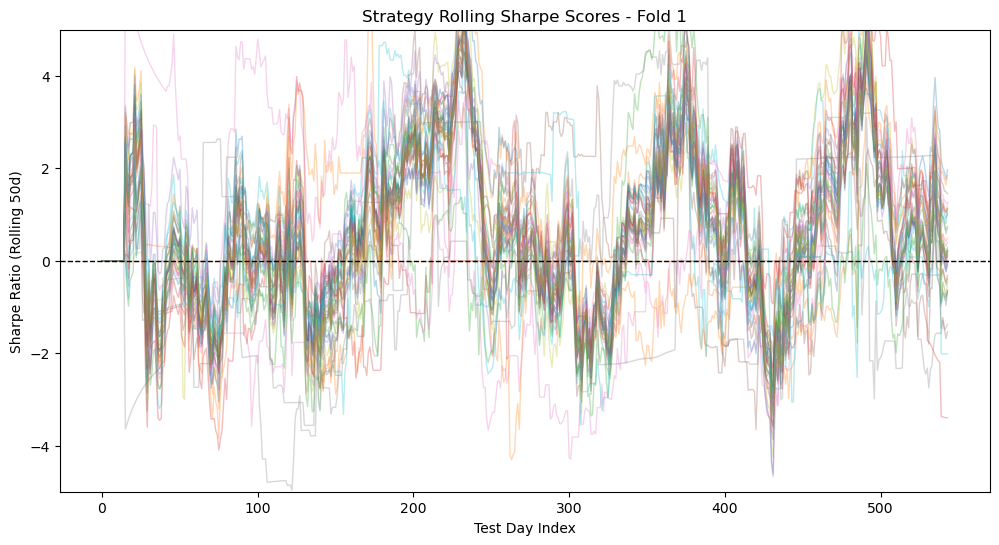

--- Starting Fold 2/10 (Days 1094 to 1637) ---

    Day 0: Top 3 leaders: [10, 21, 36], Sharpes: ['1.662', '1.599', '1.192']
    Day 60: Top 3 leaders: [1, 7, 16], Sharpes: ['0.771', '0.256', '-0.415']
    Day 120: Top 3 leaders: [27, 25, 31], Sharpes: ['3.216', '2.651', '2.479']
    Day 180: Top 3 leaders: [33, 7, 25], Sharpes: ['6.134', '5.601', '4.914']
    Day 240: Top 3 leaders: [7, 33, 11], Sharpes: ['2.817', '1.155', '-0.026']
    Day 300: Top 3 leaders: [35, 21, 8], Sharpes: ['3.279', '2.566', '2.500']
    Day 360: Top 3 leaders: [7, 31, 18], Sharpes: ['-0.063', '-0.068', '-0.231']
    Day 420: Top 3 leaders: [33, 16, 7], Sharpes: ['1.337', '0.561', '-0.205']
    Day 480: Top 3 leaders: [10, 3, 34], Sharpes: ['0.284', '-0.226', '-0.584']
    Day 540: Top 3 leaders: [38, 15, 5], Sharpes: ['3.583', '3.374', '2.936']
  Fold 2 (Daily): Strat Vol: 11.01%, Mkt Vol: 15.12%, Ret_penalty: 0.0000, Sharpe: 0.1525, Adj Sharpe: 0.1525


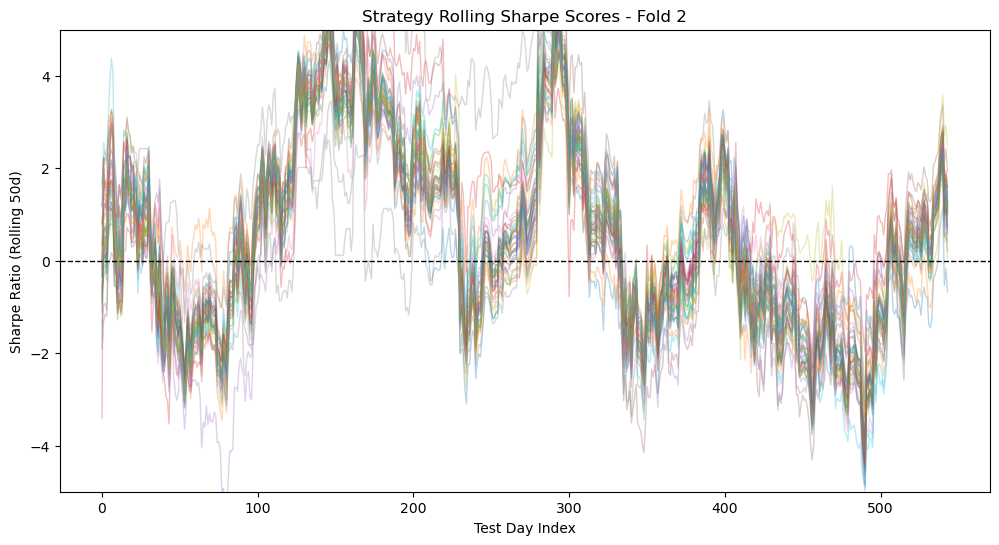

--- Starting Fold 3/10 (Days 1638 to 2181) ---

    Day 0: Top 3 leaders: [38, 15, 35], Sharpes: ['3.350', '2.518', '2.263']
    Day 60: Top 3 leaders: [30, 13, 3], Sharpes: ['0.165', '-0.232', '-0.241']
    Day 120: Top 3 leaders: [9, 18, 39], Sharpes: ['-1.826', '-1.849', '-2.136']
    Day 180: Top 3 leaders: [20, 7, 1], Sharpes: ['1.324', '1.000', '0.963']
    Day 240: Top 3 leaders: [28, 12, 15], Sharpes: ['3.962', '3.926', '3.553']
    Day 300: Top 3 leaders: [3, 32, 11], Sharpes: ['4.559', '3.756', '3.631']
    Day 360: Top 3 leaders: [38, 16, 39], Sharpes: ['4.942', '2.913', '2.846']
    Day 420: Top 3 leaders: [23, 38, 30], Sharpes: ['0.729', '0.676', '0.673']
    Day 480: Top 3 leaders: [34, 36, 30], Sharpes: ['7.382', '7.340', '7.306']
    Day 540: Top 3 leaders: [9, 38, 1], Sharpes: ['0.567', '0.521', '0.184']
  Fold 3 (Daily): Strat Vol: 19.28%, Mkt Vol: 26.92%, Ret_penalty: 0.0000, Sharpe: -0.1195, Adj Sharpe: -0.1195


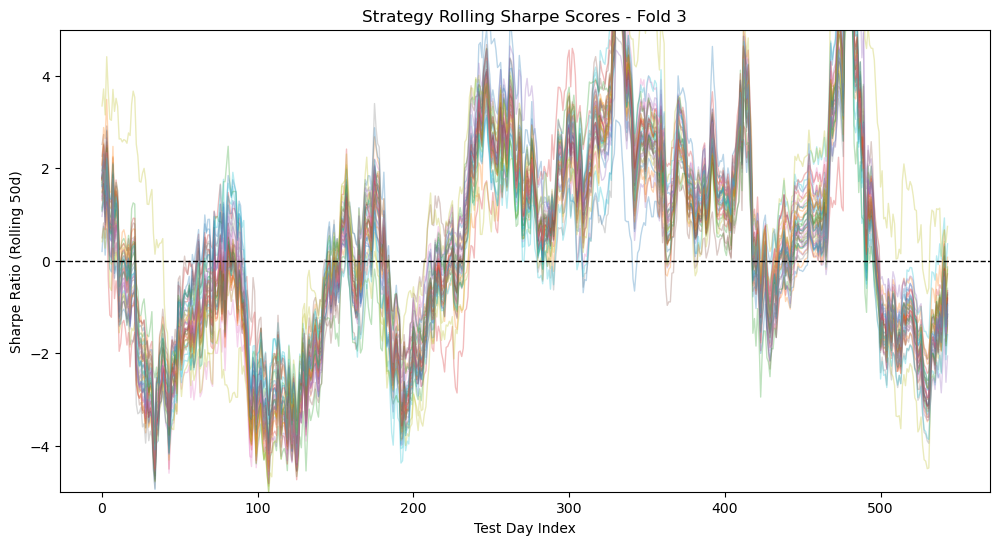

--- Starting Fold 4/10 (Days 2182 to 2725) ---

    Day 0: Top 3 leaders: [38, 9, 1], Sharpes: ['0.877', '0.169', '-0.002']
    Day 60: Top 3 leaders: [14, 28, 17], Sharpes: ['4.388', '2.849', '2.836']
    Day 120: Top 3 leaders: [28, 10, 14], Sharpes: ['5.619', '5.084', '4.795']
    Day 180: Top 3 leaders: [27, 22, 10], Sharpes: ['1.580', '1.524', '1.512']
    Day 240: Top 3 leaders: [33, 36, 2], Sharpes: ['1.752', '1.631', '1.263']
    Day 300: Top 3 leaders: [10, 36, 9], Sharpes: ['0.731', '0.208', '0.207']
    Day 360: Top 3 leaders: [29, 34, 14], Sharpes: ['3.273', '2.664', '2.205']
    Day 420: Top 3 leaders: [33, 11, 39], Sharpes: ['5.041', '4.940', '4.921']
    Day 480: Top 3 leaders: [10, 9, 21], Sharpes: ['0.438', '-0.248', '-0.334']
    Day 540: Top 3 leaders: [11, 36, 16], Sharpes: ['4.095', '3.179', '3.003']
  Fold 4 (Daily): Strat Vol: 13.82%, Mkt Vol: 17.76%, Ret_penalty: 0.1770, Sharpe: 0.8909, Adj Sharpe: 0.7569


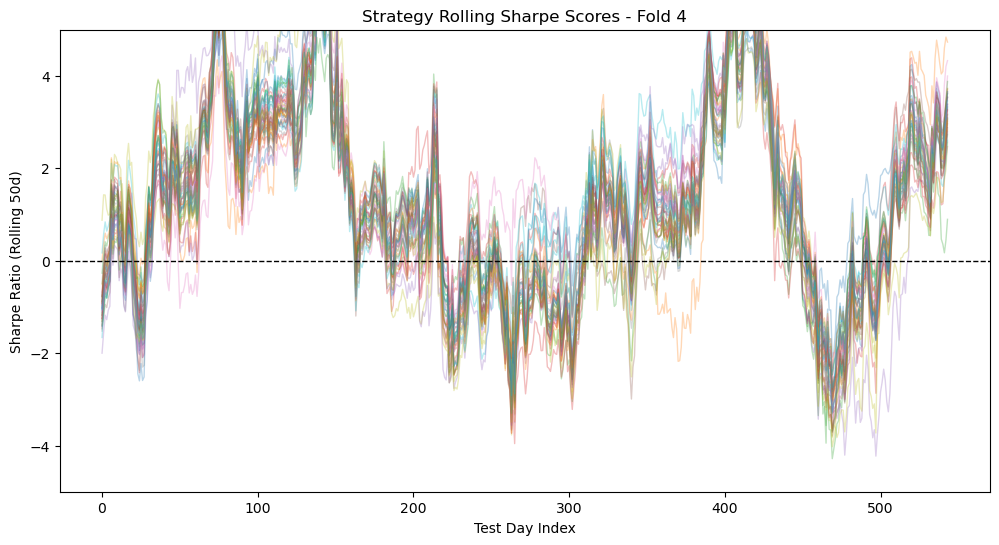

--- Starting Fold 5/10 (Days 2726 to 3269) ---

    Day 0: Top 3 leaders: [11, 36, 16], Sharpes: ['4.721', '4.372', '4.025']
    Day 60: Top 3 leaders: [37, 38, 30], Sharpes: ['1.920', '1.395', '0.401']
    Day 120: Top 3 leaders: [18, 27, 12], Sharpes: ['6.172', '6.121', '5.954']
    Day 180: Top 3 leaders: [37, 18, 9], Sharpes: ['4.570', '3.210', '2.627']
    Day 240: Top 3 leaders: [37, 34, 7], Sharpes: ['5.622', '4.500', '4.000']
    Day 300: Top 3 leaders: [10, 1, 35], Sharpes: ['3.843', '3.389', '3.203']
    Day 360: Top 3 leaders: [25, 9, 18], Sharpes: ['3.242', '3.207', '3.071']
    Day 420: Top 3 leaders: [16, 1, 15], Sharpes: ['2.042', '1.572', '1.375']
    Day 480: Top 3 leaders: [38, 35, 25], Sharpes: ['1.944', '1.755', '1.457']
    Day 540: Top 3 leaders: [37, 18, 12], Sharpes: ['4.749', '3.796', '3.280']
  Fold 5 (Daily): Strat Vol: 6.38%, Mkt Vol: 11.17%, Ret_penalty: 0.4967, Sharpe: 1.6377, Adj Sharpe: 1.0942


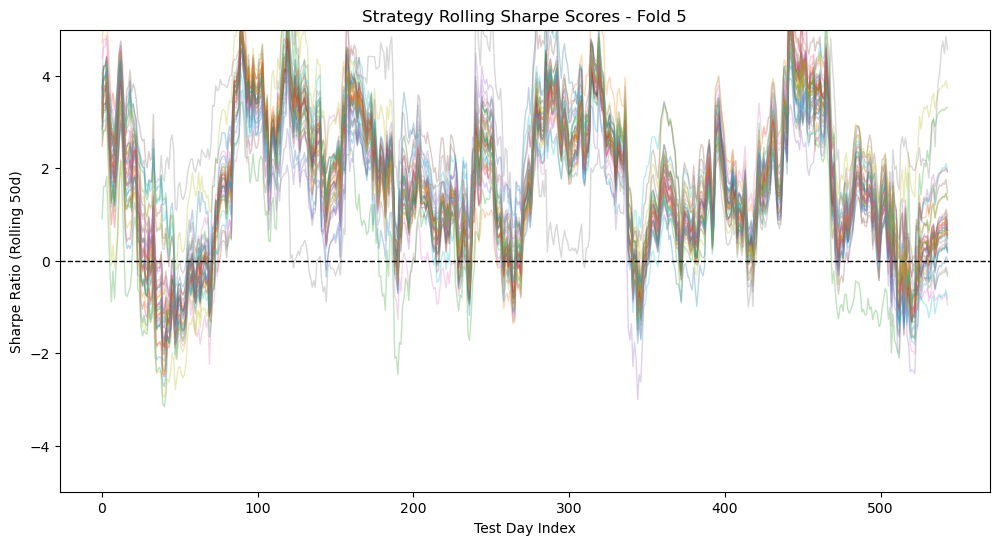

--- Starting Fold 6/10 (Days 3270 to 3813) ---

    Day 0: Top 3 leaders: [37, 18, 12], Sharpes: ['4.968', '3.859', '3.328']
    Day 60: Top 3 leaders: [23, 0, 13], Sharpes: ['1.618', '1.198', '1.177']
    Day 120: Top 3 leaders: [33, 32, 9], Sharpes: ['0.899', '0.609', '0.433']
    Day 180: Top 3 leaders: [1, 2, 12], Sharpes: ['0.052', '0.005', '-0.045']
    Day 240: Top 3 leaders: [24, 13, 23], Sharpes: ['1.414', '1.411', '1.403']
    Day 300: Top 3 leaders: [31, 39, 19], Sharpes: ['0.421', '-0.447', '-0.689']
    Day 360: Top 3 leaders: [14, 32, 22], Sharpes: ['6.193', '5.810', '5.722']
    Day 420: Top 3 leaders: [18, 10, 33], Sharpes: ['2.813', '2.799', '2.643']
    Day 480: Top 3 leaders: [32, 36, 33], Sharpes: ['0.545', '0.428', '0.241']
    Day 540: Top 3 leaders: [15, 10, 38], Sharpes: ['4.476', '4.407', '4.288']
  Fold 6 (Daily): Strat Vol: 12.50%, Mkt Vol: 14.08%, Ret_penalty: 0.0608, Sharpe: 0.3541, Adj Sharpe: 0.3338


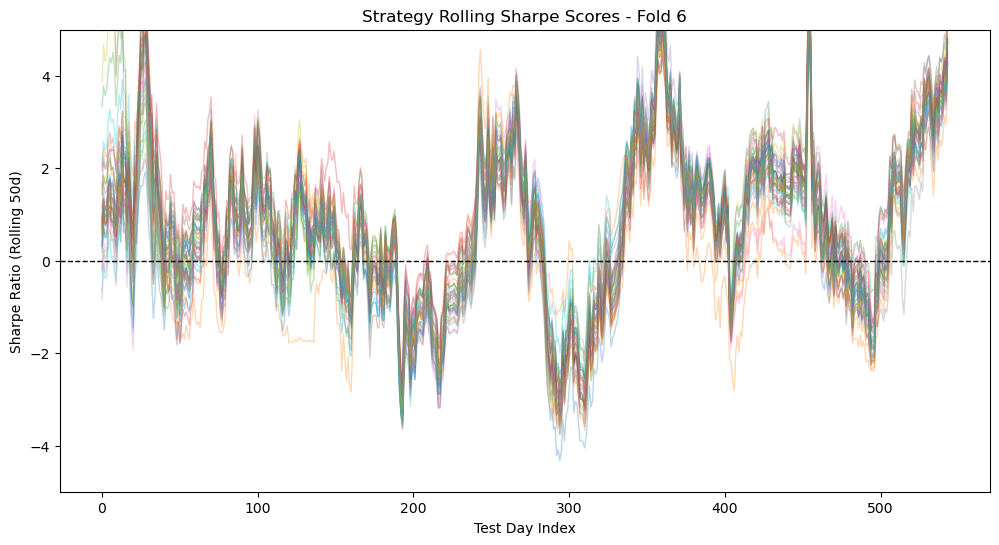

--- Starting Fold 7/10 (Days 3814 to 4357) ---

    Day 0: Top 3 leaders: [10, 15, 8], Sharpes: ['5.698', '5.484', '5.256']
    Day 60: Top 3 leaders: [38, 35, 10], Sharpes: ['3.109', '2.792', '2.785']
    Day 120: Top 3 leaders: [39, 15, 31], Sharpes: ['1.747', '1.653', '1.601']
    Day 180: Top 3 leaders: [28, 18, 11], Sharpes: ['2.631', '2.611', '2.594']
    Day 240: Top 3 leaders: [27, 5, 4], Sharpes: ['4.880', '4.772', '4.609']
    Day 300: Top 3 leaders: [13, 2, 21], Sharpes: ['-0.129', '-0.334', '-0.500']
    Day 360: Top 3 leaders: [1, 11, 21], Sharpes: ['2.668', '2.668', '2.585']
    Day 420: Top 3 leaders: [18, 38, 30], Sharpes: ['3.861', '3.726', '3.655']
    Day 480: Top 3 leaders: [4, 33, 19], Sharpes: ['-1.011', '-1.313', '-1.357']
    Day 540: Top 3 leaders: [26, 31, 18], Sharpes: ['4.863', '4.737', '4.671']
  Fold 7 (Daily): Strat Vol: 10.66%, Mkt Vol: 12.90%, Ret_penalty: 0.0000, Sharpe: 1.0871, Adj Sharpe: 1.0871


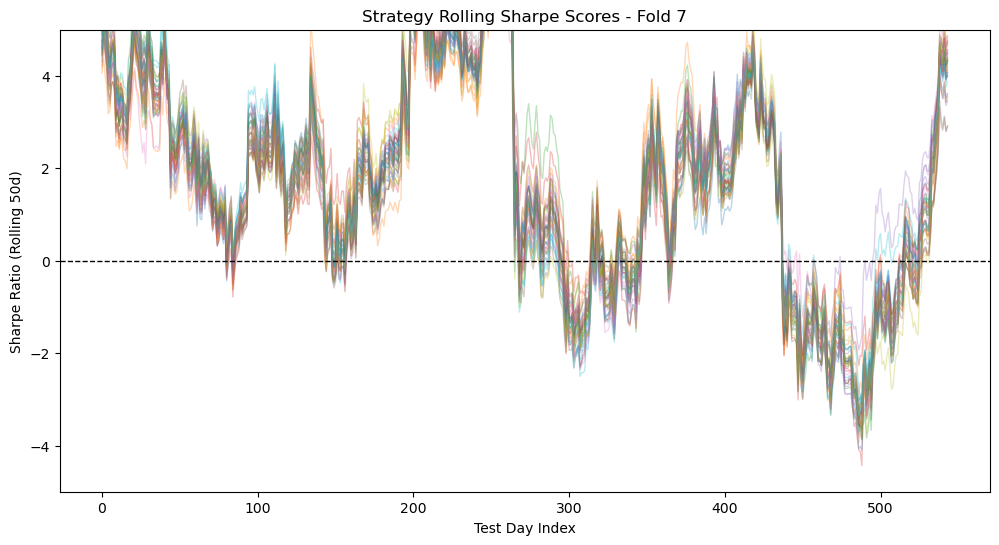

--- Starting Fold 8/10 (Days 4358 to 4901) ---

    Day 0: Top 3 leaders: [38, 31, 10], Sharpes: ['6.445', '6.360', '6.268']
    Day 60: Top 3 leaders: [12, 8, 15], Sharpes: ['1.262', '1.111', '0.732']
    Day 120: Top 3 leaders: [3, 16, 37], Sharpes: ['2.415', '1.293', '1.136']
    Day 180: Top 3 leaders: [36, 23, 7], Sharpes: ['3.411', '2.831', '2.547']
    Day 240: Top 3 leaders: [26, 10, 34], Sharpes: ['2.457', '-1.018', '-1.297']
    Day 300: Top 3 leaders: [36, 37, 33], Sharpes: ['2.241', '2.140', '2.113']
    Day 360: Top 3 leaders: [37, 12, 36], Sharpes: ['3.169', '3.011', '2.835']
    Day 420: Top 3 leaders: [26, 8, 12], Sharpes: ['0.752', '0.477', '0.476']
    Day 480: Top 3 leaders: [17, 36, 33], Sharpes: ['3.549', '3.294', '3.176']
    Day 540: Top 3 leaders: [37, 22, 20], Sharpes: ['4.214', '4.192', '4.175']
  Fold 8 (Daily): Strat Vol: 17.44%, Mkt Vol: 19.67%, Ret_penalty: 0.0080, Sharpe: 1.1807, Adj Sharpe: 1.1713


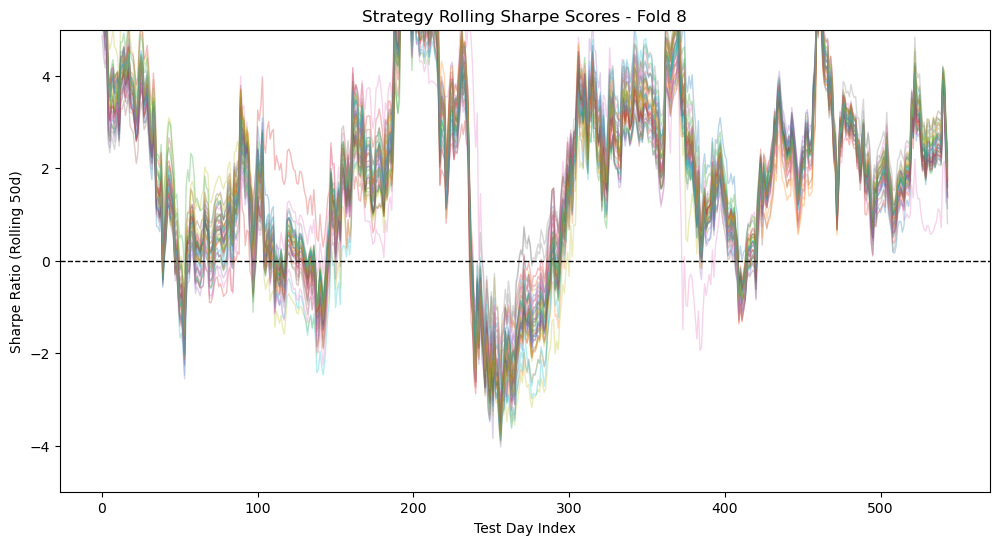

--- Starting Fold 9/10 (Days 4902 to 5445) ---

    Day 0: Top 3 leaders: [6, 18, 3], Sharpes: ['3.646', '3.612', '3.335']
    Day 60: Top 3 leaders: [22, 9, 23], Sharpes: ['3.492', '3.397', '3.336']
    Day 120: Top 3 leaders: [24, 27, 37], Sharpes: ['2.166', '2.056', '2.034']
    Day 180: Top 3 leaders: [38, 19, 21], Sharpes: ['-0.866', '-0.930', '-1.081']
    Day 240: Top 3 leaders: [19, 18, 31], Sharpes: ['-0.302', '-0.526', '-0.772']
    Day 300: Top 3 leaders: [25, 27, 24], Sharpes: ['1.031', '0.846', '0.545']
    Day 360: Top 3 leaders: [3, 10, 33], Sharpes: ['-1.715', '-1.777', '-1.907']
    Day 420: Top 3 leaders: [4, 23, 29], Sharpes: ['0.822', '0.785', '0.729']
    Day 480: Top 3 leaders: [19, 21, 10], Sharpes: ['0.728', '0.701', '0.644']
    Day 540: Top 3 leaders: [37, 29, 28], Sharpes: ['3.425', '3.395', '3.226']
  Fold 9 (Daily): Strat Vol: 18.67%, Mkt Vol: 18.85%, Ret_penalty: 0.4747, Sharpe: -0.1930, Adj Sharpe: -0.1309


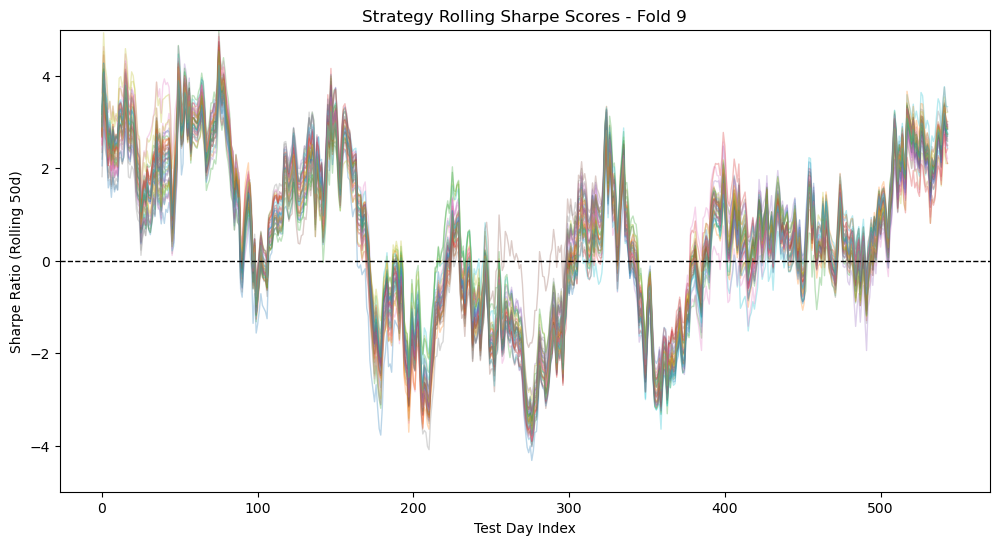

--- Starting Fold 10/10 (Days 5446 to 5989) ---

    Day 0: Top 3 leaders: [29, 37, 28], Sharpes: ['3.729', '3.637', '3.633']
    Day 60: Top 3 leaders: [9, 32, 16], Sharpes: ['-1.893', '-1.900', '-2.028']
    Day 120: Top 3 leaders: [30, 17, 39], Sharpes: ['4.876', '4.726', '4.650']
    Day 180: Top 3 leaders: [16, 39, 12], Sharpes: ['4.304', '4.168', '4.120']
    Day 240: Top 3 leaders: [10, 25, 39], Sharpes: ['4.091', '4.046', '4.034']
    Day 300: Top 3 leaders: [1, 32, 20], Sharpes: ['1.171', '0.877', '0.870']
    Day 360: Top 3 leaders: [31, 2, 39], Sharpes: ['3.111', '2.778', '2.631']
    Day 420: Top 3 leaders: [13, 16, 27], Sharpes: ['-0.605', '-0.635', '-0.729']
    Day 480: Top 3 leaders: [32, 35, 38], Sharpes: ['1.583', '1.376', '1.327']
    Day 540: Top 3 leaders: [20, 35, 19], Sharpes: ['3.262', '3.188', '3.069']
  Fold 10 (Daily): Strat Vol: 12.75%, Mkt Vol: 14.14%, Ret_penalty: 0.0026, Sharpe: 0.9692, Adj Sharpe: 0.9667


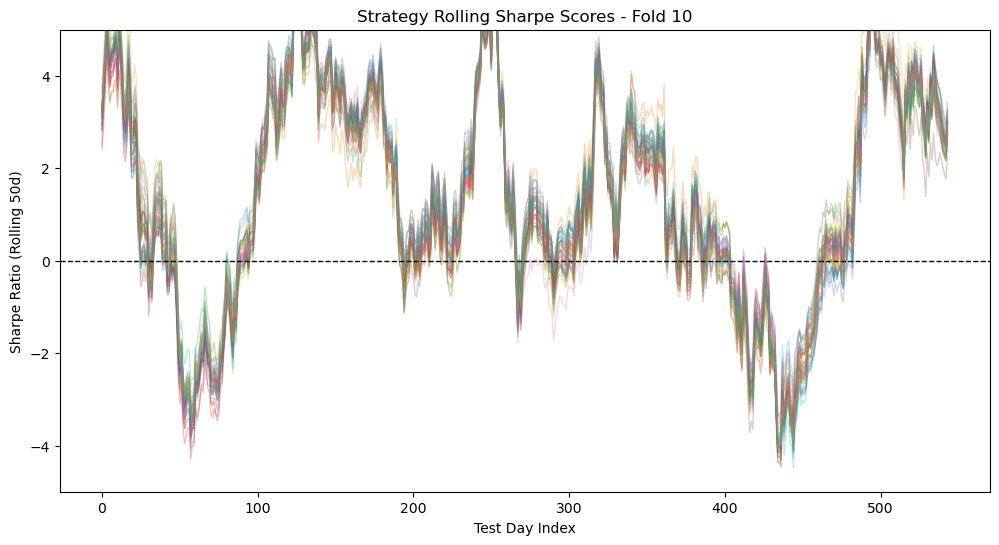


--- CV Finished ---
Mean Ensembled CV Score (Daily Re-ranking): 0.5274, std: 0.5142

--- Overall OOS Performance (Daily Re-ranking) ---
  Fold 10 (Daily): Strat Vol: 13.52%, Mkt Vol: 16.76%, Ret_penalty: 0.0557, Sharpe: 0.4976, Adj Sharpe: 0.4713
 Overall Ensembled Score: 0.4713


0.4713191600197642

In [27]:

def evaluate(excessarg: int) -> float:
    """
    Main evaluation function for FunSearch. It loads the data
    and runs the solver which performs cross-validation.
    """
    full_train_df = pl.read_csv(TRAIN_DATA_PATH)
    # Use a slice of data for faster evaluation runs during development
    df_raw = full_train_df.slice(3000)
    print(df_raw.shape)

    #fill nulls in df with mean
    df = df_raw.with_columns(
        # Select all numeric columns for the operation
        pl.selectors.numeric()
          # Step 1: Attempt to fill with the rolling mean of each respective column
          .fill_null(
              pl.selectors.numeric().rolling_mean(window_size=5, min_periods=1)
          )
          # Step 2: Fall back to the global column mean for any remaining nulls
          #.fill_null(strategy='mean')
    )
    df = df.with_columns(
    pl.col("date_id").cast(pl.Int64)
    )
    
    weekday_df = add_weekday_column(SPY_DATA_PATH)
    print("\n--- Joining weekday feature onto sliced data ---")
    # Join the weekday information onto the sliced training data.
    # A 'left' join ensures we keep all rows from the original `df`.
    df_with_features = df.join(weekday_df, on="date_id", how="left")
    # print("DataFrame after join:")
    # print(df_with_features.shape)
    return solve(df_with_features)
  
def add_weekday_column(input_csv_path: str) -> pl.DataFrame:
    """
    Reads a CSV file, adds a 'weekday' column based on the 'Date' column,
    and saves the result to a new CSV file.

    Args:
        input_csv_path (str): The path to the source CSV file.
        output_csv_path (str): The path where the output CSV will be saved.
    """
    # Read the CSV file into a Polars DataFrame
    df = pl.read_csv(input_csv_path)

    # Add a new column named 'weekday'
    # 1. Select the 'Date' column.
    # 2. Convert the string representation to a proper date type.
    # 3. Use the .dt.weekday() function to get the day of the week (Monday=1, Sunday=7).
    # 4. Alias the new expression to 'weekday'.
    df_with_weekday = df.with_columns(
        pl.col("Date").str.to_date().dt.weekday().alias("weekday")
    )

    # Print the transformed DataFrame to the console to show the result
    returned_df = df_with_weekday.select(["date_id", "weekday"])
    return returned_df

import warnings
warnings.filterwarnings('ignore', message='.*XGBoost is not compiled with CUDA support.*')

evaluate(0)